<a href="https://colab.research.google.com/github/orhansonmeztr/Bio-LLMs/blob/main/scincl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q
!pip install sacremoses -q
!pip install scann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd 
from platform import python_version
import os 
import sklearn
import json
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import math
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')
from math import log2
import torch
from scipy.spatial.distance import cosine
from transformers import AutoTokenizer, AutoModel

In [4]:
tokenizer = AutoTokenizer.from_pretrained('malteos/scincl')
model = AutoModel.from_pretrained('malteos/scincl')

In [6]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def split_chunks(data):
    return [data[x:x + 10] for x in range(0, len(data), 10)]

In [7]:
def get_vectors(chunks):
    title_vecs = []
    abstract_vecs = []
    for chunk in chunks:
        #papers = [{'title': chunk[i]['title'], 'abstract': chunk[i]['abstract']} for i in range(len(chunk))]
        title = [d['title'] for d in chunk]
        abstract = [d['abstract'] for d in chunk]

        inputs = tokenizer(title, padding=True, truncation=True, return_tensors="pt", max_length=512)
        result = model(**inputs)
        embedT = result.last_hidden_state[:, 0, :]
        title_vecs.extend(vector_normalizer(embedT.detach().numpy()))

        inputs = tokenizer(abstract, padding=True, truncation=True, return_tensors="pt", max_length=512)
        result = model(**inputs)
        embedA = result.last_hidden_state[:, 0, :]
        abstract_vecs.extend(vector_normalizer(embedA.detach().numpy()))

    return title_vecs, abstract_vecs

In [10]:
# os.listdir('drive/MyDrive/transfer/patent')
os.chdir('/content/drive/MyDrive/vectors_via_biogpt_variants/')

In [11]:
dset="biotech"
modelname="scincl"
f = open('vec_vectorized_biotech_patents_transformed_ols.json', "r")
data = json.loads(f.read())
chunks = split_chunks(data)
title_vectors_norm, abst_vectors_norm = get_vectors(chunks)

In [12]:
# np.save('data_biotech_title_scincl_norm.npy', title_vectors_norm)
# np.save('data_biotech_abstract_scincl_norm.npy', abst_vectors_norm)

In [19]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    #mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        # mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit #, mrr

In [20]:
biotech_abstract_scincl_norm = np.load('data_biotech_abstract_scincl_norm.npy')
biotech_title_scincl_norm = np.load('data_biotech_title_scincl_norm.npy')
biotech_abstract_scincl_norm.shape

(484, 768)

In [21]:
pca_abstract_scincl = PCA().fit(biotech_abstract_scincl_norm)
pca_var_scincl = np.cumsum(pca_abstract_scincl.explained_variance_ratio_)

In [22]:
svd_abstract_scincl = TruncatedSVD(n_iter= 25, n_components = 768).fit(biotech_abstract_scincl_norm)
svd_var_scincl = np.cumsum(svd_abstract_scincl.explained_variance_ratio_)

In [23]:
print('PCA 100% :',np.where(np.array(pca_var_scincl) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_scincl) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_scincl) >= 0.90)[0][0])

print('SVD 100% :',np.where(np.array(svd_var_scincl) >= 0.99)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_scincl) >= 0.95)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_scincl) >= 0.90)[0][0])

PCA 100% : 123
PCA 95% : 68
PCA 90% : 46
SVD 100% : 124
SVD 95% : 69
SVD 90% : 47


In [31]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)+ "_" + modelname
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save(dset + '_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save(dset + '_title_vectors_norm'+pca_name,title_vectors_pca)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)+ "_" + modelname
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(content_vectors_svd))
    inverse_title = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(title_vectors_svd))

    np.save(dset + '_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save(dset + '_title_vectors_norm'+svd_name,title_vectors_svd)
    joblib.dump(svd_, svd_name)

In [34]:
pca_reducer(47, biotech_abstract_scincl_norm, biotech_title_scincl_norm)
pca_reducer(69, biotech_abstract_scincl_norm, biotech_title_scincl_norm)
pca_reducer(124, biotech_abstract_scincl_norm, biotech_title_scincl_norm)
pca_reducer(107, biotech_abstract_scincl_norm, biotech_title_scincl_norm)

svd_reducer(47, biotech_abstract_scincl_norm, biotech_title_scincl_norm)
svd_reducer(69, biotech_abstract_scincl_norm, biotech_title_scincl_norm)
svd_reducer(124, biotech_abstract_scincl_norm, biotech_title_scincl_norm)
svd_reducer(107, biotech_abstract_scincl_norm, biotech_title_scincl_norm)

In [35]:
abstract_pca_47 = np.load(dset + '_abst_vectors_norm_pca_47'+ '_' + modelname + '.npy')
title_pca_47 = np.load(dset + '_title_vectors_norm_pca_47'+ '_' + modelname + '.npy')

abstract_pca_69 = np.load(dset + '_abst_vectors_norm_pca_69'+ '_' + modelname + '.npy')
title_pca_69 = np.load(dset + '_title_vectors_norm_pca_69'+ '_' + modelname + '.npy')

abstract_pca_124 = np.load(dset + '_abst_vectors_norm_pca_124'+ '_' + modelname + '.npy')
title_pca_124 = np.load(dset + '_title_vectors_norm_pca_124'+ '_' + modelname + '.npy')

abstract_pca_107 = np.load(dset + '_abst_vectors_norm_pca_107'+ '_' + modelname + '.npy')
title_pca_107 = np.load(dset + '_title_vectors_norm_pca_107'+ '_' + modelname + '.npy')


abstract_svd_47 = np.load(dset + '_abst_vectors_norm_svd_47'+ '_' + modelname + '.npy')
title_svd_47 = np.load(dset + '_title_vectors_norm_svd_47'+ '_' + modelname + '.npy')

abstract_svd_69 = np.load(dset + '_abst_vectors_norm_svd_69'+ '_' + modelname + '.npy')
title_svd_69 = np.load(dset + '_title_vectors_norm_svd_69'+ '_' + modelname + '.npy')

abstract_svd_124 = np.load(dset + '_abst_vectors_norm_svd_124'+ '_' + modelname + '.npy')
title_svd_124 = np.load(dset + '_title_vectors_norm_svd_124'+ '_' + modelname + '.npy')

abstract_svd_107 = np.load(dset + '_abst_vectors_norm_svd_107'+ '_' + modelname + '.npy')
title_svd_107 = np.load(dset + '_title_vectors_norm_svd_107'+ '_' + modelname + '.npy')

In [36]:
searcher_raw = scann.scann_ops_pybind.builder(biotech_abstract_scincl_norm, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_pca_47 = scann.scann_ops_pybind.builder(abstract_pca_47, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_69 = scann.scann_ops_pybind.builder(abstract_pca_69, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_124 = scann.scann_ops_pybind.builder(abstract_pca_124, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107 = scann.scann_ops_pybind.builder(abstract_pca_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_svd_47 = scann.scann_ops_pybind.builder(abstract_svd_47, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_69 = scann.scann_ops_pybind.builder(abstract_svd_69, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_124 = scann.scann_ops_pybind.builder(abstract_svd_124, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_107 = scann.scann_ops_pybind.builder(abstract_svd_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [37]:
raw_idx = []
reduced_idx_pca_47 = []
reduced_idx_svd_47 = []
reduced_idx_pca_69 = []
reduced_idx_svd_69 = []
reduced_idx_pca_124 = []
reduced_idx_svd_124 = []
reduced_idx_pca_107 = []
reduced_idx_svd_107 = []
for i in range(len(biotech_abstract_scincl_norm)):
    raw_idx.append(searcher_raw.search(biotech_abstract_scincl_norm[i])[0])
    reduced_idx_pca_47.append(searcher_pca_47.search(title_pca_47[i])[0])
    reduced_idx_svd_47.append(searcher_svd_47.search(title_svd_47[i])[0])
    reduced_idx_pca_69.append(searcher_pca_69.search(title_pca_69[i])[0])
    reduced_idx_svd_69.append(searcher_svd_69.search(title_svd_69[i])[0])
    reduced_idx_pca_124.append(searcher_pca_124.search(title_pca_124[i])[0])
    reduced_idx_svd_124.append(searcher_svd_124.search(title_svd_124[i])[0])
    reduced_idx_pca_107.append(searcher_pca_107.search(title_pca_107[i])[0])
    reduced_idx_svd_107.append(searcher_svd_107.search(title_svd_107[i])[0])

In [38]:
k = [1,3,5,10,15,20,30]
ap_pca_47, hit_pca_47 = metrics_calculator(raw_idx,reduced_idx_pca_47, k )
ap_svd_47, hit_svd_47 = metrics_calculator(raw_idx,reduced_idx_svd_47, k )

ap_pca_69, hit_pca_69 = metrics_calculator(raw_idx,reduced_idx_pca_69, k )
ap_svd_69, hit_svd_69 = metrics_calculator(raw_idx,reduced_idx_svd_69, k )

ap_pca_124, hit_pca_124 = metrics_calculator(raw_idx,reduced_idx_pca_124, k )
ap_svd_124, hit_svd_124 = metrics_calculator(raw_idx,reduced_idx_svd_124, k )

ap_pca_107, hit_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_107, k )
ap_svd_107, hit_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_107, k )

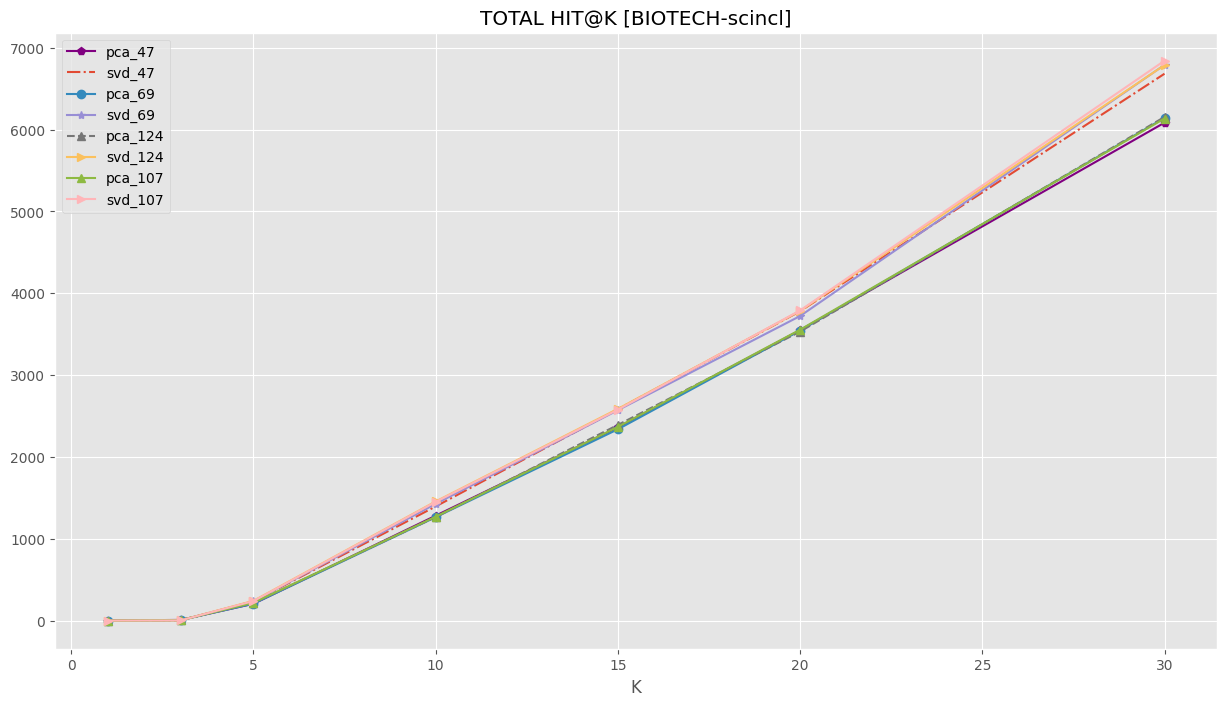

In [39]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_47, '-p', color = 'purple')
plt.plot(k,hit_svd_47, '-.')
plt.plot(k,hit_pca_69, '-o')
plt.plot(k,hit_svd_69, '-*')
plt.plot(k,hit_pca_124, '--^')
plt.plot(k,hit_svd_124, '>-')
plt.plot(k,hit_pca_107, '^-')
plt.plot(k,hit_svd_107, '->')

plt.title('TOTAL HIT@K [BIOTECH-scincl]')
plt.legend(['pca_47','svd_47','pca_69','svd_69','pca_124','svd_124','pca_107','svd_107'])
plt.xlabel('K');

In [40]:
print(hit_pca_47)
print(hit_pca_69)
print(hit_pca_124)
print(hit_pca_107)
print("-"*50)
print(hit_svd_47)
print(hit_svd_69)
print(hit_svd_124)
print(hit_svd_107)

[2, 10, 207, 1283, 2362, 3549, 6084]
[0, 8, 208, 1265, 2339, 3545, 6143]
[0, 7, 218, 1266, 2392, 3532, 6154]
[0, 7, 220, 1271, 2368, 3555, 6135]
--------------------------------------------------
[1, 4, 236, 1396, 2583, 3781, 6682]
[0, 4, 237, 1428, 2572, 3722, 6790]
[1, 4, 243, 1457, 2588, 3785, 6788]
[1, 4, 240, 1452, 2578, 3790, 6841]
